In [47]:
# !pip install numpy pandas pandas_ta matplotlib yfinance keras tensorflow

In [48]:
# Importing libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import pandas_ta as ta

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing libraries for fetching financial data
import yfinance as yf

# Importing libraries for deep learning with Keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

# Importing additional libraries
import datetime


In [49]:
ROOT='./kaggle/input/dt23-test/series'

def csv_to_df_handler(path):
    out_df = pd.read_csv(ROOT+path,index_col='timestamp')
    out_df.index = pd.to_datetime(out_df.index)
    out_df = out_df.sort_index(ascending=True).replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)
    return out_df

In [50]:


def fetch_data_from_yfinance_handler(symbol):
    df = yf.download(tickers=symbol, start='2000-01-01').interpolate(method='linear')
    return df


In [51]:
SPY_df = fetch_data_from_yfinance_handler('SPY')
# SPY_df.head()

ISRG_df = fetch_data_from_yfinance_handler('ISRG')
ISRG_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-06-16,2.013889,2.055556,2.000000,2.027778,2.027778,521550
2000-06-19,2.027778,2.055556,2.000000,2.000000,2.000000,1363050
2000-06-20,2.006944,2.180556,1.750000,2.083333,2.083333,1177650
2000-06-21,2.222222,2.472222,2.138889,2.444444,2.444444,2342250
2000-06-22,2.458333,2.472222,2.118056,2.194444,2.194444,857700


In [52]:
ISRG_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-30,260.079987,261.149994,254.850006,258.489990,258.489990,2277800
2023-10-31,260.390015,263.950012,260.170013,262.220001,262.220001,2373300
2023-11-01,262.170013,272.179993,262.000000,270.459991,270.459991,2087300
2023-11-02,274.570007,278.149994,272.630005,277.890015,277.890015,1965800
2023-11-03,280.220001,281.579987,277.390015,278.519989,278.519989,1310500


In [53]:
help(ta.bop)

Help on function bop in module pandas_ta.momentum.bop:

bop(open_, high, low, close, scalar=None, talib=None, offset=None, **kwargs)
    Balance of Power (BOP)
    
    Balance of Power measure the market strength of buyers against sellers.
    
    Sources:
        http://www.worden.com/TeleChartHelp/Content/Indicators/Balance_of_Power.htm
    
    Calculation:
        BOP = scalar * (close - open) / (high - low)
    
    Args:
        open (pd.Series): Series of 'open's
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        scalar (float): How much to magnify. Default: 1
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method
    
   

In [54]:


def add_indicators(data):
    # Trend Indicators
    data['EMA12'] = ta.ema(data['Adj Close'], length=12)
    data['EMA25'] = ta.ema(data['Adj Close'], length=25)
    data['EMA50'] = ta.ema(data['Adj Close'], length=50)
    data['EMA100'] = ta.ema(data['Adj Close'], length=100)
    data['EMA200'] = ta.ema(data['Adj Close'], length=200)
    data['BOP'] = ta.bop(open_= data['Open'], high=data['High'], low=data['Low'], close=data['Adj Close'])

    # ADX Indicator
    adx_values = ta.adx(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['ADX'] = adx_values['ADX_14']
    data['+DI'] = adx_values['DMP_14']
    data['-DI'] = adx_values['DMN_14']

    # Momentum Indicators
    data['RSI'] = ta.rsi(data['Adj Close'], length=15)
    
    # Stochastic Oscillator
    stoch_values = ta.stoch(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['STOCH_K'] = stoch_values['STOCHk_14_3_3']  # Stochastic %K line
    data['STOCH_D'] = stoch_values['STOCHd_14_3_3']  # Stochastic %D line

    # Volume Indicator
    data['OBV'] = ta.obv(close=data['Adj Close'], volume=data['Volume'])

    # Volatility Indicator
    data['ZSCORE'] = ta.zscore(close=data['Adj Close'])
    bbands = ta.bbands(close=data['Adj Close'], length=20, std=2, mamode='sma')
    # print(bbands.columns)  # Print to check the column names

    # Update the DataFrame with the correct column names
    # Replace 'BB_LOWER', 'BB_MIDDLE', 'BB_UPPER' with actual column names from bbands.columns
    data['BB_LOWER'] = bbands['BBL_20_2.0']  # Update with the actual column name for lower band
    data['BB_MIDDLE'] = bbands['BBM_20_2.0']   # Update with the actual column name for middle band
    data['BB_UPPER'] = bbands['BBU_20_2.0']  # Update with the actual column name for upper band
     # MACD (also a momentum indicator)
    macd = ta.macd(data['Adj Close'], fast=12, slow=26, signal=9)
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']
    data['MACD_Hist'] = macd['MACDh_12_26_9']

    # Performance Indicators
    data['proportional_variation_compared_to_previous_day'] = ta.percent_return(data['Adj Close'], cumulative=False)
    data['proportional_variation_compared_to_start'] = ta.percent_return(data['Adj Close'], cumulative=True)

    # Target and Classification
    # data['Target'] = data['proportional_variation_compared_to_previous_day'] 
    # data['Target'] = data['Target'].shift(-1)
    # data['TargetClass'] = [1 if x > 0 else 0 for x in data['Target']]

    #target value is the percentage variation of tomorrow compared to today
    data['Target'] = data['proportional_variation_compared_to_previous_day'].shift(-1)
    data.fillna(0, inplace=True)

    return data

In [55]:
SPY_df = add_indicators(SPY_df)
SPY_df.head()

,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA25,EMA50,EMA100,...,ZSCORE,BB_LOWER,BB_MIDDLE,BB_UPPER,MACD,MACD_Signal,MACD_Hist,proportional_variation_compared_to_previous_day,proportional_variation_compared_to_start,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,94.262543,8164300,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.039106
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.576347,8089800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.039106,-0.039106,0.001789
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.738380,12177900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001789,-0.037387,-0.016072
2000-01-06,139.62500,141.50000,137.750000,137.7500,89.280045,6227200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016072,-0.052858,0.058076
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.465080,8066500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058076,0.002149,0.003431


In [56]:
def corr_heatmap(df):
    # Reset the index to remove it from the correlation calculation
    df_reset_index = df.reset_index(drop=True)
    
    graph_size = (12, 12)
    fig, ax = plt.subplots(figsize=graph_size)
    sns.heatmap(df_reset_index.corr(), ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    plt.show()


In [57]:
SPY_df.var()

Open                                               1.080806e+04
High                                               1.092042e+04
Low                                                1.068736e+04
Close                                              1.081285e+04
Adj Close                                          1.253578e+04
Volume                                             8.545323e+15
EMA12                                              1.250865e+04
EMA25                                              1.247619e+04
EMA50                                              1.240720e+04
EMA100                                             1.227058e+04
EMA200                                             1.201790e+04
BOP                                                2.108534e+02
ADX                                                6.428729e+01
+DI                                                2.481597e+01
-DI                                                2.666936e+01
RSI                                     

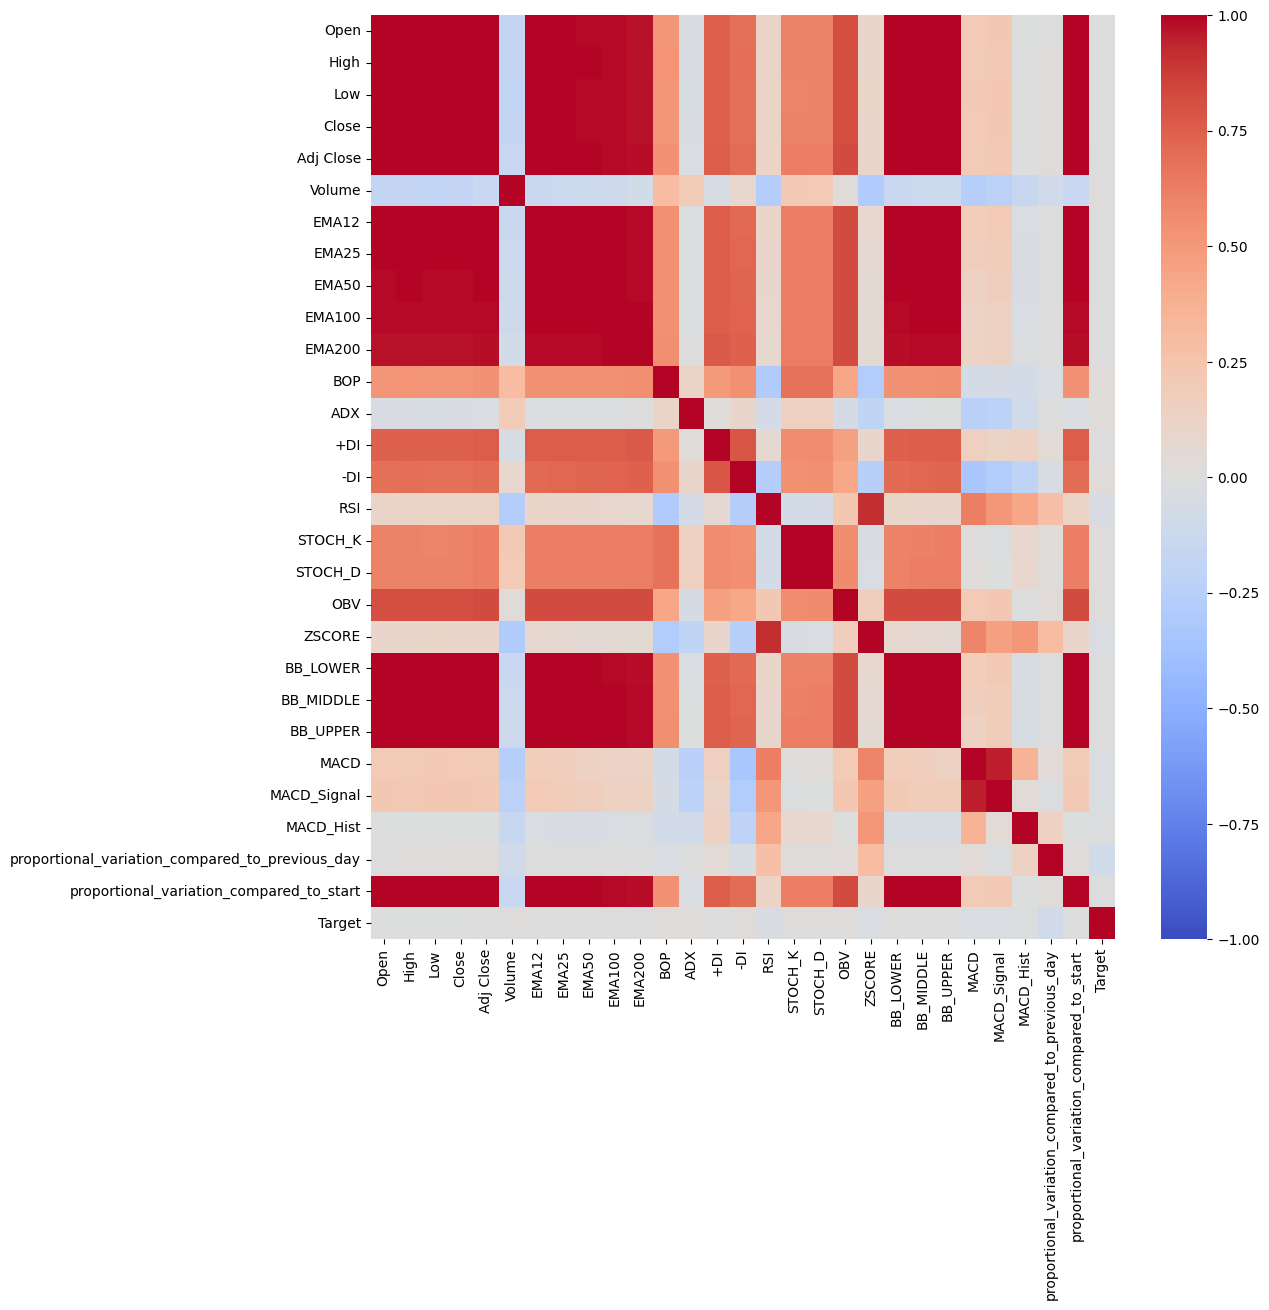

In [58]:
corr_heatmap(SPY_df)

In [59]:

sc = MinMaxScaler(feature_range=(-1,1))

def refit_data_for_ml (df, backcandles): 

    df =df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
    df = sc.fit_transform(df)
    # print(df)
    # multiple feature from data provided to the model
    X = []
    #print(data_set_scaled[0].size)
    #data_set_scaled=data_set.values
    # backcandles is the number of days back you want the machine to look at, 30 being 30 days back. 

    # every column except the last one which is the target
    input_cols_num = df.shape[1]-1
    print(input_cols_num)
    for j in range(input_cols_num):
        X.append([])
        for i in range(backcandles, df.shape[0]):#backcandles+2
            X[j].append(df[i-backcandles:i, j])

    #move axis from 0 to position 2
    X=np.moveaxis(X, [0], [2])

    #Erase first elements of y because of backcandles to match X length
    #del(yi[0:backcandles])
    #X, yi = np.array(X), np.array(yi)
    # Choose -1 for last column, classification else -2...
    X, yi =np.array(X), np.array(df[backcandles:,-1])
    y=np.reshape(yi,(len(yi),1))
    #y=sc.fit_transform(yi)
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # print(X)
    print(X.shape)
    # print(y)
    print(y.shape)
    return X,y

In [60]:
def split_ml_dataset(X,y):
    # split data into train test sets
    splitlimit = int(len(X)*0.8)
    print('---------------------------------')
    print(splitlimit)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    # print(y_train)
    return X_train,X_test, y_train, y_test

In [61]:

SPY_X,SPY_y = refit_data_for_ml(SPY_df, 10)
SPY_Xtrain, SPY_Xtest, SPY_ytrain, SPY_ytest = split_ml_dataset(SPY_X, SPY_y)


22
(5989, 10, 22)
(5989, 1)
---------------------------------
4791
(4791, 10, 22)
(1198, 10, 22)
(4791, 1)
(1198, 1)


In [62]:
print(SPY_X.shape[1])

10


In [63]:

# Set a random seed for reproducibility
np.random.seed(10)

# Define the input layer with a specific shape backcandles (days), num columns
lstm_input = Input(shape=(10, 22), name='lstm_input')

# Create the first LSTM layer with a specified number of units (neurons)
# This layer captures sequential patterns in the input data
lstm_layer = LSTM(150, name='first_layer')(lstm_input)

# Add a dense (fully connected) layer with one output unit
# You can experiment with different numbers of units for this layer
dense_layer = Dense(1, name='dense_layer1')(lstm_layer)

# Apply an activation function to the output of the second dense layer
output = Activation('linear', name='output')(dense_layer)

# Create the Keras model by specifying input and output layers
model = Model(inputs=lstm_input, outputs=output)

# Create an instance of the Adam optimizer for training
adam = tf.keras.optimizers.legacy.Adam()

# Compile the model with mean squared error (MSE) loss function
# You can specify different loss functions for each output if needed
model.compile(optimizer=adam, loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x=SPY_Xtrain,
    y=SPY_ytrain,
    batch_size=20,
    epochs=50,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/50
216/216 [==============================] - 3s 8ms/step - loss: 0.0120 - val_loss: 0.0051
Epoch 2/50
216/216 [==============================] - 1s 7ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 3/50
216/216 [==============================] - 2s 7ms/step - loss: 0.0103 - val_loss: 0.0051
Epoch 4/50
216/216 [==============================] - 2s 8ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 5/50
216/216 [==============================] - 2s 9ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 6/50
216/216 [==============================] - 2s 8ms/step - loss: 0.0098 - val_loss: 0.0066
Epoch 7/50
216/216 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 8/50
216/216 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.0051
Epoch 9/50
216/216 [==============================] - 2s 7ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 10/50
216/216 [==============================] - 2s 8ms/step - loss: 0.0098 - val_loss: 0.0055

In [64]:
# Assuming you have a model defined and trained
# Assuming 'history' is the object returned by model.fit()
# Get the last loss value
last_loss = history.history['loss'][-1]

model.save_weights(f'./model_weights/loss{last_loss: .4f}.h5')


In [65]:
y_pred = model.predict(SPY_Xtest)
#y_pred=np.where(y_pred > 0.43, 1,0)
# for i in range(10):
#     print(y_pred[i], y_test[i])

38/38 [==============================] - 0s 4ms/step


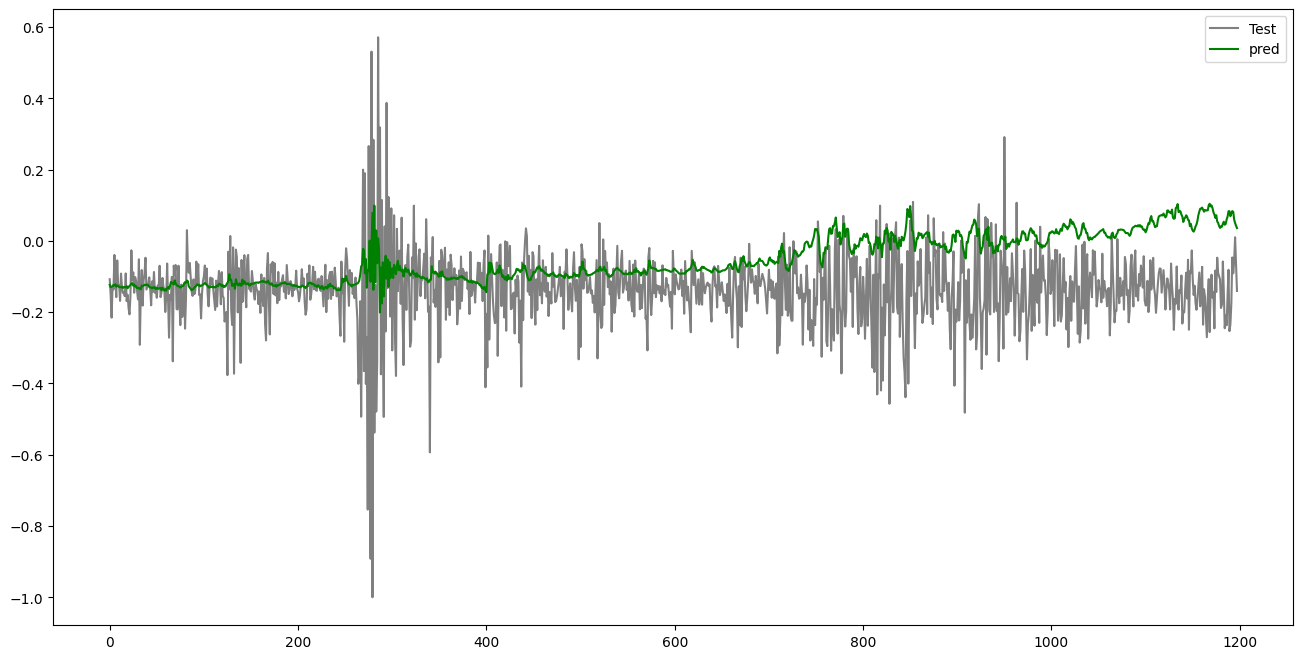

In [66]:
plt.figure(figsize=(16,8))
plt.plot(SPY_ytest, color = 'grey', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

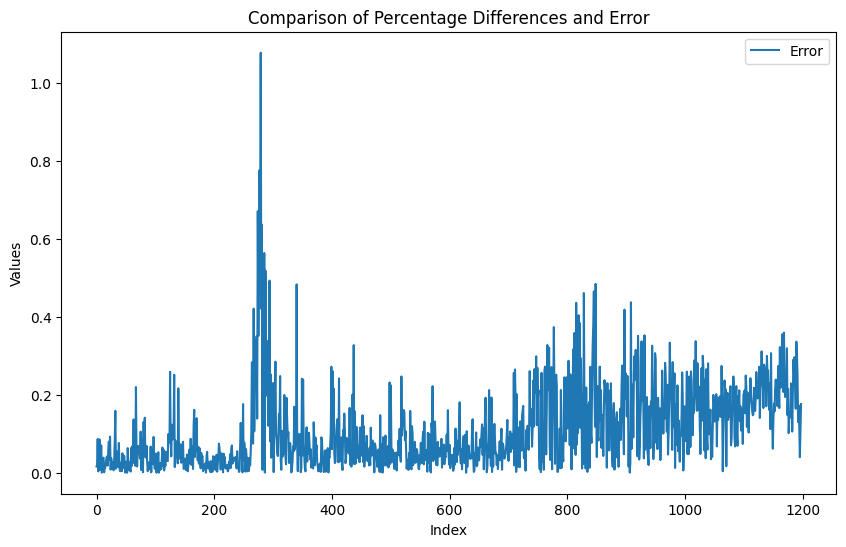

In [67]:

# Assuming you already have y_test and y_pred defined
# Create a DataFrame
model_test_out_df = pd.DataFrame({
    'SPY_ytest': SPY_ytest.flatten(),  # Flattening in case y_test is a multi-dimensional array
    'y_pred': y_pred.flatten()   # Flattening in case y_pred is a multi-dimensional array
})


# Calculate error between percentage differences
model_test_out_df['error'] = abs(model_test_out_df.SPY_ytest - model_test_out_df.y_pred)

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(model_test_out_df['pct_diff_y_test'], label='Percentage Difference y_test')
# plt.plot(model_test_out_df['pct_diff_y_pred'], label='Percentage Difference y_pred')
plt.plot(model_test_out_df['error'], label='Error')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Percentage Differences and Error')
plt.legend()
plt.show()




In [68]:
model_test_out_df

,SPY_ytest,y_pred,error
0,-0.107575,-0.123561,0.015986
1,-0.150854,-0.129920,0.020934
2,-0.215378,-0.128829,0.086549
3,-0.130904,-0.127437,0.003467
4,-0.136147,-0.123537,0.012610
...,...,...,...
1193,-0.091170,0.081529,0.172699
1194,-0.056731,0.059798,0.116529
1195,0.010031,0.050121,0.040090
1196,-0.068838,0.042363,0.111201


In [69]:
sc = MinMaxScaler(feature_range=(0,1))

def refit_data_for_ml(df, backcandles):
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
    df = sc.fit_transform(df)

    X = []
    input_cols_num = df.shape[1] - 1
    for j in range(input_cols_num):
        X.append([df[i-backcandles:i, j] for i in range(backcandles, df.shape[0])])

    X = np.moveaxis(X, 0, 2)
    X, y = np.array(X), np.array(df[backcandles:, -1])
    y = np.reshape(y, (len(y), 1))

    return X, y

def split_ml_dataset(X, y):
    splitlimit = int(len(X) * 0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]

    return X_train, X_test, y_train, y_test

def define_and_train_model(X_train, y_train):
    np.random.seed(10)

    lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='lstm_input')
    lstm_layer = LSTM(150, name='first_layer')(lstm_input)
    dense_layer = Dense(1, name='dense_layer1')(lstm_layer)
    output = Activation('linear', name='output')(dense_layer)

    model = Model(inputs=lstm_input, outputs=output)
    adam = tf.keras.optimizers.Adam()

    model.compile(optimizer=adam, loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=20,
        epochs=50,
        shuffle=True,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

    return model, history

def save_model_weights(model, history):
    last_loss = history.history['loss'][-1]
    model.save_weights(f'./model_weights/loss{last_loss: .4f}.h5')

def train_pipeline(dfs, backcandles):
    combined_df = pd.concat(dfs, ignore_index=True)
    X, y = refit_data_for_ml(combined_df, backcandles)
    X_train, X_test, y_train, y_test = split_ml_dataset(X, y)
    model, history = define_and_train_model(X_train, y_train)
    save_model_weights(model, history)
    return model

def predict_pipeline(dfs, model, backcandles):
    predictions = []
    for df in dfs:
        X, _ = refit_data_for_ml(df, backcandles)
        y_pred = model.predict(X)
        predictions.append(y_pred)
    return predictions
